# Inférence de la GRAVITE à partir des données de MRV (Stratégie ML Naive)
La variable GRAVITE représente la grvité de l'évenement avec 5 echelons




**Stratégie ML 1**

Dans ce problème de classification de texte multiclasse, le pipeline sera le suivant :
1. Nettoyer les données textuelles 
2. Nettoyage des observations (Traitement des doublons au moment de la séparation du train et du test)
3. Construction des features textuelles (Deux tfidf)
4. Entrainement de l'algorithme de classification (SVM probabilisé)
5. Evaluation du modèle (Accuracy, Balanced Accuracy, F1-weighted)


## 0) Chargement des librairies

In [28]:
import warnings
#warnings.filterwarnings('ignore')

from pprint import pprint
from time import time
import logging

import pandas as pd

import numpy as np
import sklearn as sk
import seaborn as sns

import nltk
from nltk import word_tokenize
lang ='french'

import clean_text





import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,f1_score
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import TruncatedSVD,IncrementalPCA,SparsePCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV

import spacy
nlp =spacy.load('fr')
from spacy.lang.fr.stop_words import STOP_WORDS

## 0.1 Chargement et exploration des données
### 0.1.1 voir le notebook exploration pour l'analyse du champs de gravité

In [3]:
%time
df_declaration_mrv = pd.read_csv("data/data_mrv/declaration_mrv_complet.csv")#delimiter=';',encoding='ISO-8859-1')
id_to_dco = pd.read_csv("data/ref_MRV/referentiel_dispositif.csv",delimiter=';',encoding='ISO-8859-1')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.3 µs


In [4]:
df_declaration_mrv['GRAVITE'].unique()

array(['MOYEN', 'NULLE', 'MINEU', nan, 'SEVER', 'CRITI'], dtype=object)

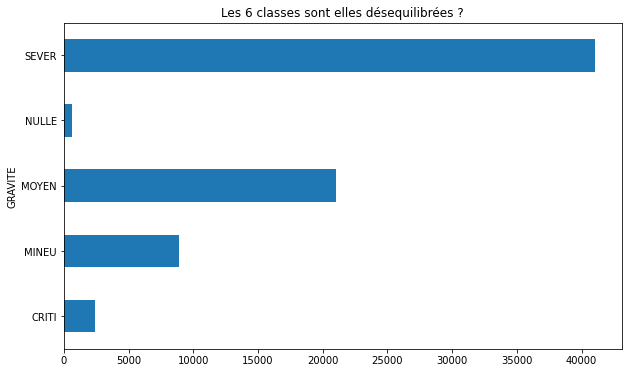

In [5]:
df_declaration_mrv.groupby('GRAVITE').count()['DCO_ID'].plot(kind ='barh',figsize=(10,6))
plt.title("Les "+ str(len(df_declaration_mrv['GRAVITE'].unique())) +" classes sont elles désequilibrées ?")
plt.show()

### 0.1.2 Gestion des NaN

In [5]:
df_declaration_mrv['GRAVITE'].isna().sum()/len(df_declaration_mrv)

0.038139667853522886

## Conclusion : 
Pour construire notre classifier, nous devons gérer les valeurs nulles, nous avons décider de simplement les éliminer car elle ne représente que 3% du data set.

Dans ce  notebook, nous appliquons simplement le SVM en supprimant les NaN  pour la classification de la gravité. Pour cela nous utiliserons les variables : 
- DESCRIPTION_INCIDENT',
- 'TYPE_VIGILANCE'
- 'LIBELLE_COMMERCIAL'
- 'REFERENCE_COMMERCIALE',
- 'ETAT_PATIENT',
- 'FABRICANT',
- 'CLASSIFICATION

Pour inférer : 
- GRAVITE

## 1) Constructions du jeux d'évaluation
On met de coté environ 20% du dataset pour l'évaluation et on ne garde pour l'entrainement seulement les classes avec plus de 10 observations

In [31]:
%%time
df_declaration_mrv = pd.read_csv("data/data_mrv/declaration_mrv_complet.csv")#delimiter=';',encoding='ISO-8859-1')
id_to_dco = pd.read_csv("data/ref_MRV/referentiel_dispositif.csv",delimiter=';',encoding='ISO-8859-1')

#Supression des NaN

#Charegement des colonnes utiles et suppression des NaN

df = df_declaration_mrv[['DESCRIPTION_INCIDENT','TYPE_VIGILANCE','LIBELLE_COMMERCIAL','DCO_ID',
                         'REFERENCE_COMMERCIALE','ETAT_PATIENT','ACTION_PATIENT','FABRICANT',
                          'GRAVITE','CLASSIFICATION']][df_declaration_mrv['GRAVITE'].notna()]

# On complète les NaN avec du vide
df['ETAT_PATIENT'] = df['ETAT_PATIENT'].fillna("")
df['DESCRIPTION_INCIDENT'] = df['DESCRIPTION_INCIDENT'].fillna("")
df['LIBELLE_COMMERCIAL'] = df['LIBELLE_COMMERCIAL'].fillna("")
df['FABRICANT'] = df['FABRICANT'].fillna("")
df["REFERENCE_COMMERCIALE"] = df['REFERENCE_COMMERCIALE'].fillna("")
df['TYPE_VIGILANCE'] = df['TYPE_VIGILANCE'].fillna("")
df['CLASSIFICATION'] = df['CLASSIFICATION'].fillna('')
df['ACTION_PATIENT'] = df['ACTION_PATIENT'].fillna('')
df['DCO_ID'] = df['DCO_ID'].fillna(-1)

# On ajoute des collones pertinentes
df['des_lib'] = df['LIBELLE_COMMERCIAL']+ ' ' + df['DESCRIPTION_INCIDENT']
df['fab_lib'] = df['LIBELLE_COMMERCIAL']+ ' ' + df['FABRICANT']
df['com'] = df['LIBELLE_COMMERCIAL']+ ' ' + df['REFERENCE_COMMERCIALE']
df['Text'] = df['LIBELLE_COMMERCIAL']+ ' ' + df['FABRICANT'] + "" + df['DESCRIPTION_INCIDENT']

# On nettoie les données :
for col in  ['DESCRIPTION_INCIDENT','LIBELLE_COMMERCIAL','ETAT_PATIENT','Text',"des_lib","fab_lib"] :
        df[col] = df[col].map(lambda x: clean_text.preprocess_text(x))

n = 15
# On filtre pour a voir plus de n observations par classse
df_n = df.groupby("GRAVITE").filter(lambda x: len(x) > n)

# On encode les labels
def GRAVITE_ENC(x):
    if x =='NULLE':
        return 0
    elif x == 'MINEU':
        return 1
    elif x == 'MOYEN':
        return 2
    elif x== 'SEVER':
        return 3
    elif x== 'CRITI':
        return 4
df_n.GRAVITE = df_n.GRAVITE.map(lambda x:GRAVITE_ENC(x))

#OnEncode les autres varibles
#le = LabelEncoder()
#On encode le type de vigilance
#df_n.TYPE_VIGILANCE = le.fit_transform(df_n.TYPE_VIGILANCE.values)
#On encode la classifcation 
#df_n.CLASSIFICATION = le.fit_transform(df_n.CLASSIFICATION.values)
#on encode le DCO
#df_n.DCO_ID = le.fit_transform(df_n.DCO_ID.values)

# On selection les variables de test en faisant attention aux doublons
train_index,test_index = next(GroupShuffleSplit(random_state=1029).split(df_n, groups=df_n['DESCRIPTION_INCIDENT']))


df_train, df_test = df_n.iloc[train_index], df_n.iloc[test_index]


CPU times: user 42.2 s, sys: 456 ms, total: 42.7 s
Wall time: 42.7 s


In [ ]:
enc_di = {
    'NULLE':0,
    'MINEU':1,
    'MOYEN':2,
    'SEVER':3,
    'CRITI':4
}

In [ ]:
dec_di = {
    0:'NULLE',
    1:'MINEU',
    2:'MOYEN',
    3:'SEVER',
    4:'CRITI'
}

## 2) Construction du pipeline  pour la gravité ordonnée

In [43]:
%%time
preprocess = ColumnTransformer(
    [('etat_pat_tfidf', TfidfVectorizer(sublinear_tf=True, min_df=3,ngram_range=(1, 1),
                                       stop_words=STOP_WORDS,
                                       max_features = 10000,norm = 'l2'), 'ETAT_PATIENT'),
     
     ('description_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=5,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 10000,norm = 'l2'), 'DESCRIPTION_INCIDENT'),
     
     ('action_pat_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                           ngram_range=(1, 1),
                           stop_words=STOP_WORDS,
                           max_features = 10000,norm = 'l2'), 'ACTION_PATIENT'),
     
     ('fabricant_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                           ngram_range=(1, 1),
                           stop_words=STOP_WORDS,
                           max_features = 5000,norm = 'l2'), 'FABRICANT'),
     ('classification_enc', TfidfVectorizer(sublinear_tf=True, min_df=5,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 100,norm = 'l2'),'CLASSIFICATION')
     
     #('vigilance_enc', OneHotEncoder(handle_unknown='ignore'),'TYPE_VIGILANCE')
     
    ],
    #
    remainder='passthrough')


pipeline = Pipeline([
    ('vect', preprocess),
    ('clf', CalibratedClassifierCV(LinearSVC(class_weight='balanced'),cv=3, method='isotonic')),
])

X = df_train[['DESCRIPTION_INCIDENT','ETAT_PATIENT','ACTION_PATIENT','FABRICANT','CLASSIFICATION']] # 
y = df_train.GRAVITE
CV = 5

result= cross_validate(pipeline, X, y, scoring=['accuracy','balanced_accuracy','f1_weighted' ], cv=CV)

CPU times: user 1min 27s, sys: 216 ms, total: 1min 27s
Wall time: 1min 27s


In [44]:
pd.DataFrame(result)[['test_accuracy','test_balanced_accuracy','test_f1_weighted']].mean()

test_accuracy             0.701789
test_balanced_accuracy    0.454091
test_f1_weighted          0.691113
dtype: float64

In [26]:
pd.DataFrame(result)[['test_accuracy','test_balanced_accuracy','test_f1_weighted']].mean()

test_accuracy             0.702603
test_balanced_accuracy    0.454830
test_f1_weighted          0.692314
dtype: float64

In [45]:
%%time
pipeline.fit(X,y)

y_pred = pipeline.predict(df_test[['CLASSIFICATION','TYPE_VIGILANCE','DESCRIPTION_INCIDENT','ETAT_PATIENT','ACTION_PATIENT','FABRICANT']])
y_true = df_test.GRAVITE

print('précision:',accuracy_score(y_pred,y_true))
print('présision pondéré: ', balanced_accuracy_score(y_pred,y_true))
print('f1_weighted : ',f1_score(y_pred,y_true,average='weighted'))

import joblib
filename = 'Gravité_1234_model.sav'
joblib.dump(pipeline, filename)

précision: 0.7282702666755336
présision pondéré:  0.686421237726189
f1_weighted :  0.7381628504866938
CPU times: user 26.1 s, sys: 104 ms, total: 26.2 s
Wall time: 26.2 s


['Gravité_1234_model.sav']

## 3) Construction du pipeline  pour la gravité binaire

In [46]:
%%time
df_declaration_mrv = pd.read_csv("data/data_mrv/declaration_mrv_complet.csv")#delimiter=';',encoding='ISO-8859-1')
id_to_dco = pd.read_csv("data/ref_MRV/referentiel_dispositif.csv",delimiter=';',encoding='ISO-8859-1')

#Supression des NaN

#Charegement des colonnes utiles et suppression des NaN

df = df_declaration_mrv[['DESCRIPTION_INCIDENT','TYPE_VIGILANCE','LIBELLE_COMMERCIAL','DCO_ID',
                         'REFERENCE_COMMERCIALE','ETAT_PATIENT','ACTION_PATIENT','FABRICANT',
                          'GRAVITE','CLASSIFICATION']][df_declaration_mrv['GRAVITE'].notna()]

# On complète les NaN avec du vide
df['ETAT_PATIENT'] = df['ETAT_PATIENT'].fillna("")
df['DESCRIPTION_INCIDENT'] = df['DESCRIPTION_INCIDENT'].fillna("")
df['LIBELLE_COMMERCIAL'] = df['LIBELLE_COMMERCIAL'].fillna("")
df['FABRICANT'] = df['FABRICANT'].fillna("")
df["REFERENCE_COMMERCIALE"] = df['REFERENCE_COMMERCIALE'].fillna("")
df['TYPE_VIGILANCE'] = df['TYPE_VIGILANCE'].fillna("")
df['CLASSIFICATION'] = df['CLASSIFICATION'].fillna('')
df['ACTION_PATIENT'] = df['ACTION_PATIENT'].fillna('')
df['DCO_ID'] = df['DCO_ID'].fillna(-1)

# On ajoute des collones pertinentes
df['des_lib'] = df['LIBELLE_COMMERCIAL']+ ' ' + df['DESCRIPTION_INCIDENT']
df['fab_lib'] = df['LIBELLE_COMMERCIAL']+ ' ' + df['FABRICANT']
df['com'] = df['LIBELLE_COMMERCIAL']+ ' ' + df['REFERENCE_COMMERCIALE']
df['Text'] = df['LIBELLE_COMMERCIAL']+ ' ' + df['FABRICANT'] + "" + df['DESCRIPTION_INCIDENT']

# On nettoie les données :
for col in  ['DESCRIPTION_INCIDENT','LIBELLE_COMMERCIAL','ETAT_PATIENT','Text',"des_lib","fab_lib"] :
        df[col] = df[col].map(lambda x: clean_text.preprocess_text(x))

n = 15
# On filtre pour a voir plus de n observations par classse
df_n = df.groupby("GRAVITE").filter(lambda x: len(x) > n)

# On encode les labels
def GRAVITE_ENC(x):
    if x =='CRITI':
        return 0
    else :
        return 1
df_n.GRAVITE = df_n.GRAVITE.map(lambda x:GRAVITE_ENC(x))

#OnEncode les autres varibles
le = LabelEncoder()
#On encode le type de vigilance
#df_n.TYPE_VIGILANCE = le.fit_transform(df_n.TYPE_VIGILANCE.values)
#On encode la classifcation 
#df_n.CLASSIFICATION = le.fit_transform(df_n.CLASSIFICATION.values)
#on encode le DCO
#df_n.DCO_ID = le.fit_transform(df_n.DCO_ID.values)

# On selection les variables de test en faisant attention aux doublons
train_index,test_index = next(GroupShuffleSplit(random_state=1029).split(df_n, groups=df_n['DESCRIPTION_INCIDENT']))


df_train, df_test = df_n.iloc[train_index], df_n.iloc[test_index]

CPU times: user 38.4 s, sys: 364 ms, total: 38.7 s
Wall time: 38.7 s


In [47]:
%%time

X = df_train[['CLASSIFICATION','DESCRIPTION_INCIDENT','ETAT_PATIENT','ACTION_PATIENT','FABRICANT']] # 
y = df_train.GRAVITE
CV = 5

result= cross_validate(pipeline, X, y, scoring=['accuracy','balanced_accuracy','f1_weighted' ], cv=CV)

CPU times: user 1min 1s, sys: 332 ms, total: 1min 1s
Wall time: 1min 1s


In [48]:
pd.DataFrame(result)[['test_accuracy','test_balanced_accuracy','test_f1_weighted']].mean()

test_accuracy             0.979909
test_balanced_accuracy    0.732818
test_f1_weighted          0.976971
dtype: float64

In [49]:
%%time
pipeline.fit(X,y)

y_pred = pipeline.predict(df_test[['CLASSIFICATION','DESCRIPTION_INCIDENT','ETAT_PATIENT','ACTION_PATIENT','FABRICANT']])
y_true = df_test.GRAVITE

print('précision:',accuracy_score(y_pred,y_true))
print('présision pondéré: ', balanced_accuracy_score(y_pred,y_true))
print('f1_weighted : ',f1_score(y_pred,y_true,average='weighted'))

précision: 0.9819777881226308
présision pondéré:  0.9029068008069009
f1_weighted :  0.9840389945633716
CPU times: user 16.7 s, sys: 92 ms, total: 16.8 s
Wall time: 16.8 s


In [51]:
import joblib
filename = 'Gravité_01_model.sav'
joblib.dump(pipeline, filename)

['Gravité_01_model.sav']

In [37]:
print('f1_binary : ',f1_score(y_pred,y_true,average='binary',pos_label=0))

f1_binary :  0.6352624495289367


In [50]:
print('f1_binary : ',f1_score(y_pred,y_true,average='binary',pos_label=0))

f1_binary :  0.6282578875171467
